# Load the data

In [1]:
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()
PRETRAINED_MODEL = "vit_b_16"

In [2]:
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
import pandas as pd

from src.training.pretrainedModels import get_pretrained_model
from src.pickle_loader import save_object

CHANNELS = [7, 2, 1]
NUM_CLASSES = 10
NUM_AUG = 1

_, transform = get_pretrained_model(PRETRAINED_MODEL)

df = pd.read_csv(config.TRAIN_FILE)

encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, config.DATA_DIR + "on_hot_encoder")


In [3]:
from sklearn.model_selection import train_test_split
from src.datasets.EuroSatMS import EuroSatMS

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
print(df['label'].unique())
test_df, val_df = train_test_split(val_df, test_size=0.7)

ds_train = EuroSatMS(
    train_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform
)

ds_val = EuroSatMS(
    val_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform
)

ds_test = EuroSatMS(
    test_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS,
    transform=transform
)

print(f"""\n{c.OKGREEN}Train dataset:      {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKGREEN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']

Preloading images...

Images:         21600
Augmentations:  21600
Jobs:           -4 

Time taken:      0 min 38.03554081916809 sec 

Preloading images...

Images:         3780
Augmentations:  3780
Jobs:           -4 

Time taken:      0 min 2.349013328552246 sec 

Preloading images...

Images:         1620
Augmentations:  1620
Jobs:           -4 

Time taken:      0 min 1.355602741241455 sec 

Train dataset:      21600 samples
Validation dataset: 3780 samples
Test dataset:       1620 samples


In [4]:
import kornia.augmentation as K
from torch import nn

p1, p2, p3 = 0.5, 0.75, 0.4
augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=p1),
    K.RandomVerticalFlip(p=p1),
    K.RandomAffine(degrees=30, translate=None, scale=None, shear=None, resample="nearest", padding_mode=2, p=p2),
    K.RandomShear(shear=0.2, resample="nearest", padding_mode=2, p=p2),
    K.RandomBrightness((0.7, 1.3), p=p2),
    K.RandomContrast(contrast=(0.8, 1.2), p=p2),
    K.RandomSaturation((0.9, 1.1), p=p2),
    K.RandomPlasmaContrast(roughness=(0.1, 0.4), p=p3),
    K.RandomSolarize(thresholds=0.1, p=p3),
    K.RandomSharpness(sharpness=(0.1, 0.3), p=p3),
    # K.RandomBoxBlur(kernel_size=(3, 3), p=p1),
    # K.RandomEqualize(p=p1),
    K.CenterCrop(size=(64, 64)),
)

ds_train.augment = augmentation
ds_val.augment = augmentation
ds_test.augment = None

# CNN Model Training

In [ ]:
import numpy as np
from src.training.data import EuroSatDataModule

BATCH_SIZE = 32
data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)
print(f"""{c.OKGREEN}Initialized the data module...{c.ENDC}""")

KERNEL_SIZE = [5, 3]
LEARNING_RATE = 0.03
MOMENTUM = 0.9
GAMMA = 0.9
DROPOUT = 0.3
EPOCHS = 15
CKPT_PATH = 'checkpoints/cnn/'
CLASS_WEIGHTS = {'AnnualCrop': 9,
                 'Forest': 9,
                 'HerbaceousVegetation': 8, 
                 'Highway': 9, 
                 'Industrial': 9,
                 'Pasture': 9, 
                 'PermanentCrop': 9, 
                 'Residential': 9, 
                 'River': 9, 
                 'SeaLake': 9}

w = np.array(list(CLASS_WEIGHTS.values()))
w_min, w_max = w.min(), w.max()
w = (w - w_min) / (w_max - w_min)

fname = "cnn_c"
for c in CHANNELS:
    fname += str(c)
fname += "_k"
for k in KERNEL_SIZE:
    fname += str(k)
fname += "_lr" + str(LEARNING_RATE)
fname += "_m" + str(MOMENTUM)
fname += "_g" + str(GAMMA)
fname += "_d" + str(DROPOUT)

print("Model name: ", fname)

In [ ]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from datetime import datetime

from src.training.cnn import LitEuroSatCnn

lightning_model = LitEuroSatCnn(
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE, 
    num_channels=len(CHANNELS), 
    kernel_size=KERNEL_SIZE,
    momentum=MOMENTUM,
    gamma=GAMMA,
    weights=torch.tensor(w, dtype=torch.float32),
    dropout=DROPOUT
)

logger = WandbLogger(
    project="eurosat_cnn",
    name="cnn_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename=fname + '_{epoch:02d}-{val_loss:.2f}',
    save_top_k=2, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(lightning_model, datamodule=data_module)

In [ ]:
import torchmetrics
import matplotlib.pyplot as plt

trainer.test(lightning_model, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)
metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
all_preds = np.concatenate(lightning_model.ep_out)
all_true = np.concatenate(lightning_model.ep_true)
true_ep = torch.tensor(all_true)
pred_ep = torch.tensor(all_preds)
metric.update(pred_ep, true_ep)
fig, ax = metric.plot()
plt.show()
print(encoder.categories_[0])

# Pretrained Model Training
### Training Phase 1
##### Pretrained ResNet50, ResNet18, AlexNet, ViT Model

In [5]:
import torch

from src.training.data import EuroSatDataModule
from src.training.pretrainedModels import EuroSatPreTrainedModel

BATCH_SIZE = 64
CKPT_PATH = f'checkpoints/{PRETRAINED_MODEL}/'

model, transform = get_pretrained_model(PRETRAINED_MODEL)

data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)

model_train = EuroSatPreTrainedModel(
    backbone=model,
    learning_rate=0.0001,
    layers=[],
    gamma=0.95,
    momentum=0.9,
    dropout=0.3,
    weight_decay=1e-3
)

In [6]:
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

logger = WandbLogger(
    project="eurosat_" + PRETRAINED_MODEL.split("_")[0],
    name=PRETRAINED_MODEL,
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=2, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=3,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

wandb: Currently logged in as: the-virus. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | backbone   | VisionTransformer | 85.8 M
1 | criterion  | CrossEntropyLoss  | 0     
2 | classifier | Linear            | 7.7 K 
-------------------------------------------------
7.7 K     Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.225   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [25]:
model, _ = get_pretrained_model(PRETRAINED_MODEL)

model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    "checkpoints/vit_b_16/17-23/epoch=01-val_loss=1.71.ckpt",
    backbone=model,
    learning_rate=0.0001,
    layers=[],
    gamma=0.8,
    momentum=0.9,
    dropout=0,
    weight_decay=1e-3
)

model_train.unfreeze_model_layers(7)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=2, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=2,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | backbone   | VisionTransformer | 85.8 M
1 | criterion  | CrossEntropyLoss  | 0     
2 | classifier | Linear            | 7.7 K 
-------------------------------------------------
42.5 M    Trainable params
43.3 M    Non-trainable params
85.8 M    Total params
343.225   Total estimated model params size (MB)


Unfreezing 7 layers of the backbone...
Layer                                                           Trainable    Parameters
--------------------------------------------------------------  -----------  ------------
class_token                                                     False        0k
conv_proj.weight                                                False        589k
conv_proj.bias                                                  False        0k
encoder.pos_embedding                                           False        151k
encoder.layers.encoder_layer_0.ln_1.weight                      False        0k
encoder.layers.encoder_layer_0.ln_1.bias                        False        0k
encoder.layers.encoder_layer_0.self_attention.in_proj_weight    False        1769k
encoder.layers.encoder_layer_0.self_attention.in_proj_bias      False        2k
encoder.layers.encoder_layer_0.self_attention.out_proj.weight   False        589k
encoder.layers.encoder_layer_0.self_attention.out_proj

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Restoring states from the checkpoint path at checkpoints/vit_b_16/17-50/epoch=01-val_loss=1.53.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at checkpoints/vit_b_16/17-50/epoch=01-val_loss=1.53.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7092592592592593     │
│    test_accuracy_epoch    │    0.6506172839506167     │
│         test_loss         │     1.330336332321167     │
└───────────────────────────┴───────────────────────────┘

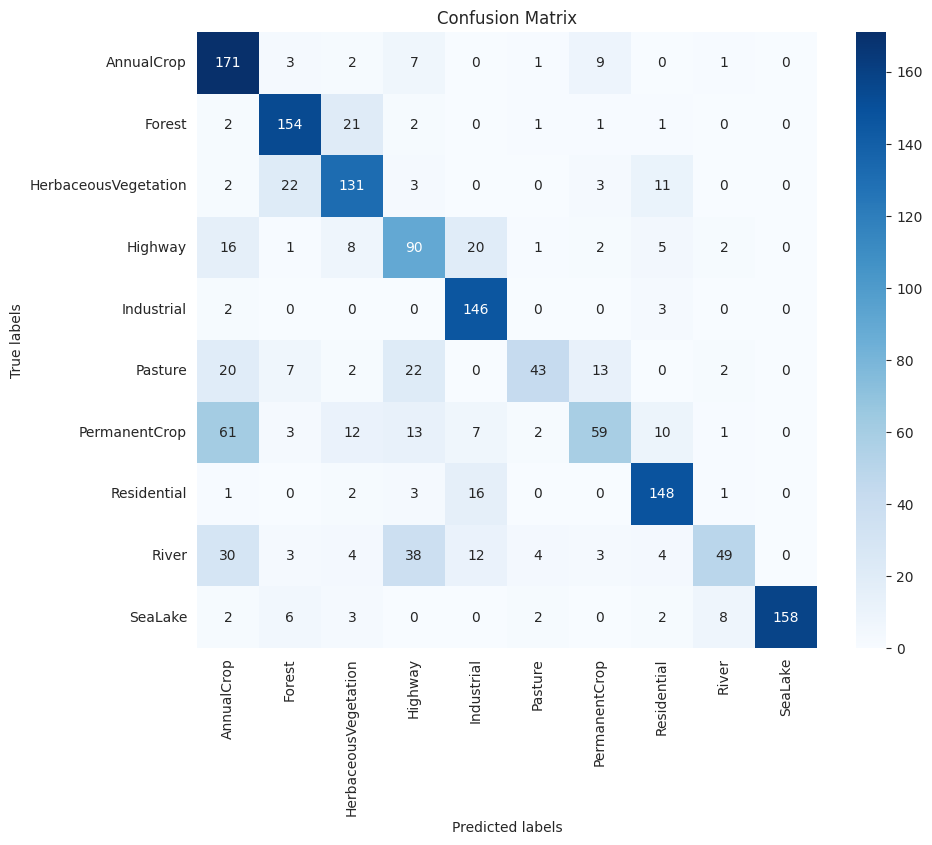

In [26]:
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)

all_preds = np.concatenate(model_train.ep_out)
all_true = np.concatenate(model_train.ep_true)
true_ep = torch.tensor(all_true)
pred_ep = torch.tensor(all_preds)

metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)
metric.update(pred_ep, true_ep)
confmat = metric.compute()
confmat_np = confmat.numpy()
tick_labels = [encoder.categories_[0][i] for i in range(NUM_CLASSES)]

plt.figure(figsize=(10, 8))
sns.heatmap(confmat_np, annot=True, fmt='g', cmap='Blues', 
            xticklabels=tick_labels, yticklabels=tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from tabulate import tabulate
from src.training.pretrainedModels import EuroSatPreTrainedModel
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from pytorch_lightning import Trainer
from src.training.data import EuroSatDataModule
import random
import numpy as np
import wandb

n_rounds = 20
gamma = 0.95
momentum = 0.9
dropout = 0.5
weight_decay = 5e-3

layers_samples = [[], [256]]

lr_samples = [0.3, 0.1, 0.05, 0.01]

bs_samples = [32, 64, 128]

param_space = [[l, b, la] for l in lr_samples for b in bs_samples for la in layers_samples]
random.shuffle(param_space)

out_table = []

for i in range(n_rounds):
    lr_hp, bs_hp, layers_hp = param_space[i]
    
    print(f"{c.OKBLUE}Round {i+1}/{n_rounds}{c.ENDC}")
    print(f"{c.OKBLUE}Learning Rate: {lr_hp:.4f}, Batch Size: {bs_hp}, Layers: {layers_hp}{c.ENDC}")
    
    data_module = EuroSatDataModule(ds_train, ds_val, ds_test, bs_hp)
    
    model = get_pretrained_model(PRETRAINED_MODEL)
    model_train = EuroSatPreTrainedModel(
        backbone=model,
        layers=layers_hp,
        learning_rate=lr_hp,
        gamma=gamma,
        momentum=momentum,
        dropout=dropout,
        weight_decay=weight_decay
    )
    
    checkpoint_callback = ModelCheckpoint(
        dirpath=CKPT_PATH + "hp_tuning" + f"/round_{i}",
        filename=f"bs_{bs_hp}_lr_{lr_hp}_ly_{layers_hp}_loss_" + '{val_loss:.2f}',
        save_top_k=1, 
        monitor="val_loss",
        verbose=False
    )

    wandb_logger = WandbLogger(
        project="eurosat_resnet",
        name=f"bs_{bs_hp}_lr_{round(lr_hp, 4)}_ly_{len(layers_hp)}",
        log_model=False,
    )

    trainer = Trainer(
        max_epochs=2,
        accelerator="gpu", 
        devices=1,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
    )

    trainer.fit(model_train, datamodule=data_module)
    trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path, verbose=False)
    score = model_train.accuracy
    out_table.append([lr_hp, bs_hp, layers_hp, score])
    print(tabulate(out_table, headers=["Learning Rate", "Batch Size", "Layers", "Accuracy"]))
    wandb.finish()
    
print(tabulate(out_table, headers=["Learning Rate", "Batch Size", "Layers", "Accuracy"]))

Round 1/20
Learning Rate: 0.3000, Batch Size: 128, Layers: []


AttributeError: 'tuple' object has no attribute 'fc'

# Predict on the test set

In [28]:
from src.datasets.EuroSatTest import EuroSatTestSet
from torch.utils.data import DataLoader
from config import Config

config = Config()

CHANNELS = [7, 2, 1]
model, transform = get_pretrained_model(PRETRAINED_MODEL)

dataset = EuroSatTestSet(config.TEST_MS_DIR, select_chan=CHANNELS, add_b10=False, transform=transform) #, augment=aug)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)



Preloading images...
Number of images: 4232
Number of jobs:   -4 

Time taken:      0 min 7.817636728286743 sec 


In [29]:
from src.training.pretrainedModels import EuroSatPreTrainedModel
from src.training.cnn import LitEuroSatCnn
from config import Config

config = Config()

# model_eval = LitEuroSatCnn.load_from_checkpoint(
#     "checkpoints/cnn/14-18/cnn_c87654_k53_lr0.03_m0.9_g0.8epoch=09-val_loss=0.68.ckpt", #checkpoint_callback.best_model_path,
#     num_classes=NUM_CLASSES,
#     learning_rate=0.025, 
#     num_channels=len(CHANNELS), 
#     kernel_size=[5, 3],
#     momentum=0.9,
#     gamma=0.9,
#     weights=torch.tensor(w, dtype=torch.float32)
# )

model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    backbone=model,
    learning_rate=1e-4,
    layers=[],
    momentum=0.9,
    dropout=0,
    weight_decay=0.0001
)

model_eval.eval()
print(checkpoint_callback.best_model_path)

checkpoints/vit_b_16/17-50/epoch=01-val_loss=1.53.ckpt


In [30]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eval = model_eval.to(device)
model_eval.eval()

N_CLASSES = 10
categorys = dataset.enc.categories_[0]
print(categorys)

predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

    
with torch.no_grad():
    for batch in dataloader:
        inputs, samp_id = batch
        inputs = inputs.to(device)
            
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = np.array(preds.cpu().numpy())
        
        pred_labels = np.array([categorys[p] for p in preds])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu())
    


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [31]:
import pandas as pd

sub_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())
print(np.array(sample_ids))

sub_df.to_csv('submission.csv', index=False)
print(np.unique(predictions, return_counts=True))

      test_id          label
2229        0        Highway
344         1    Residential
2400        2         Forest
845         3        SeaLake
1131        4  PermanentCrop
[3649 3353 2285 ...  310 1912 3893]
(array(['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
       'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River',
       'SeaLake'], dtype='<U20'), array([537, 318, 315, 874, 396, 102, 336, 399, 109, 846]))


In [ ]:
from torch.nn.functional import interpolate


def overlay_cam_on_image(im, cam_mask):
    cam_mask = (cam_mask - cam_mask.min()) / (cam_mask.max() - cam_mask.min())
    print(cam_mask.shape)

    print(im.shape)
    # Resize the CAM mask to match the image size
    cam_mask = interpolate(cam_mask, size=im.shape, mode='nearest').squeeze(0)
    print(im.shape)
    print(cam_mask.shape)
    # Convert CAM mask to heatmap
    heatmap = plt.get_cmap('jet')(cam_mask.cpu().detach().numpy())[:, :, :3]  # Get the RGB part, discard alpha
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float()

    # Overlay the heatmap on the image
    combined_img = heatmap * 0.3 + im.cpu() * 0.5  # Adjust opacity as needed

    return combined_img

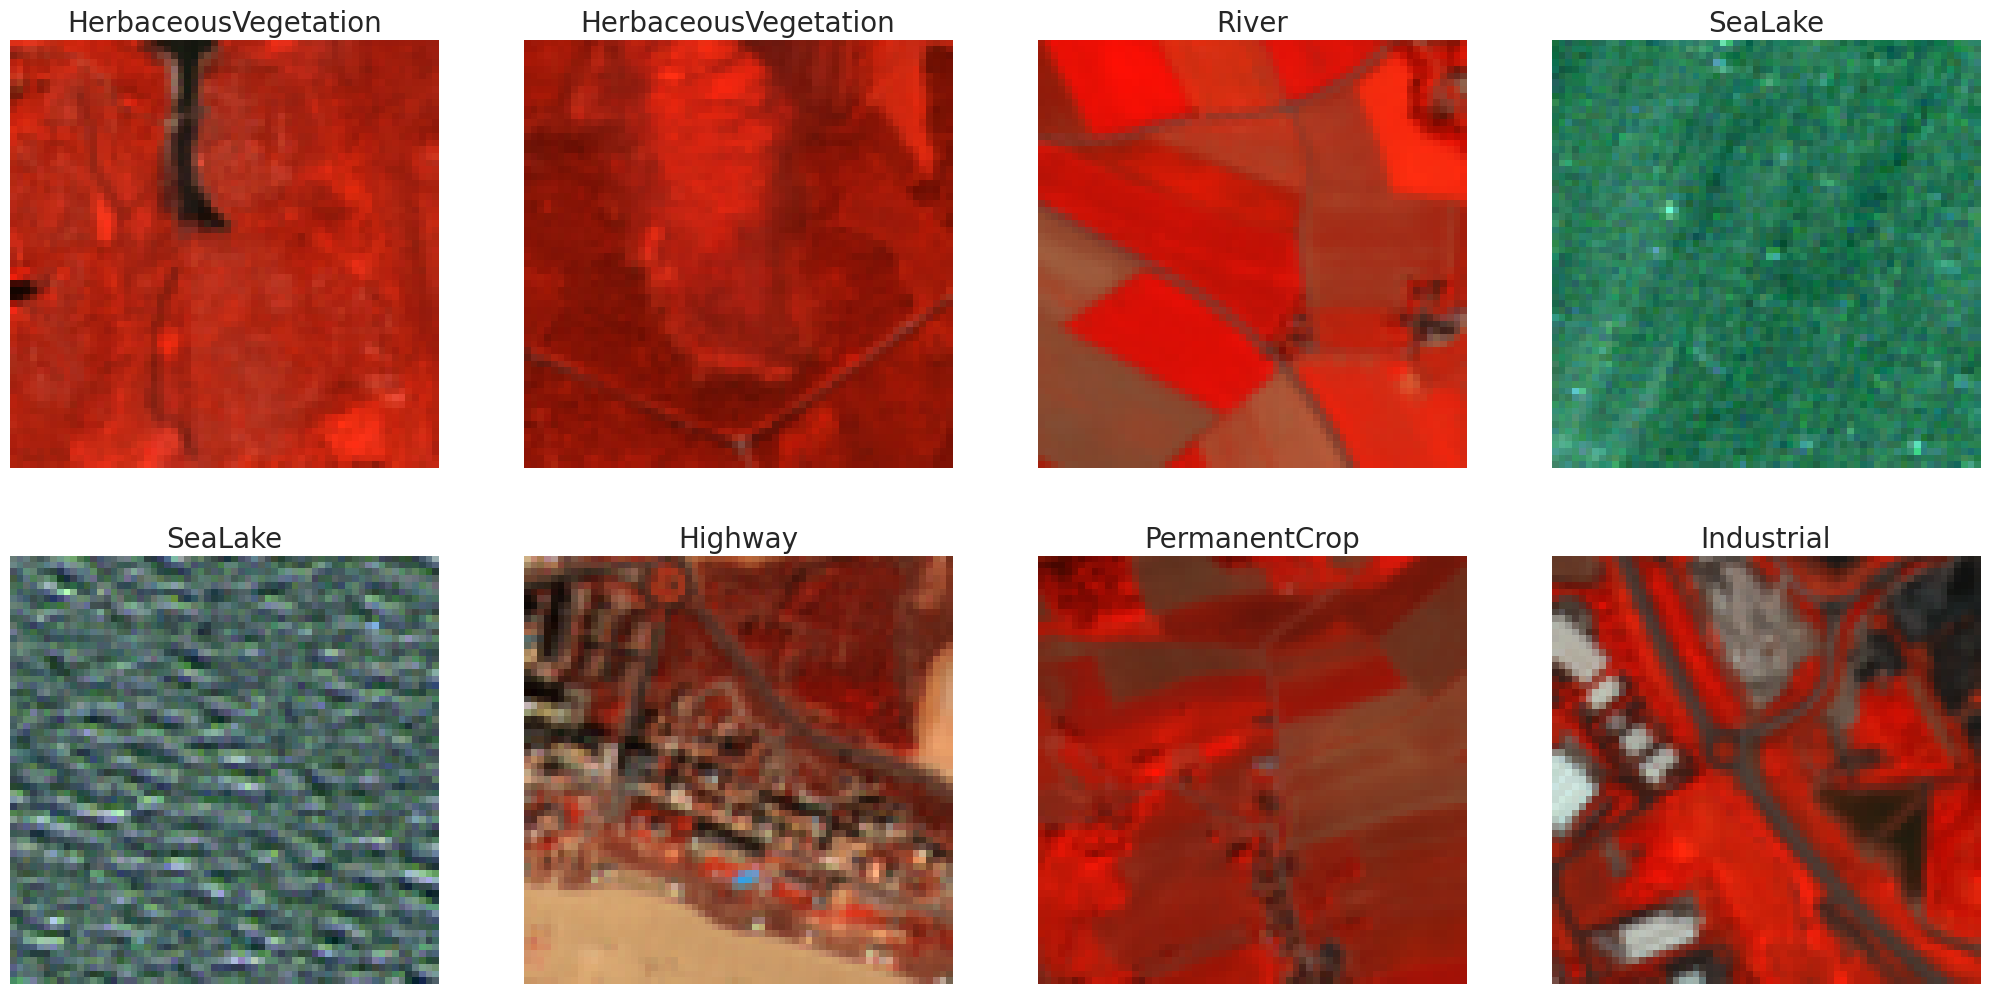

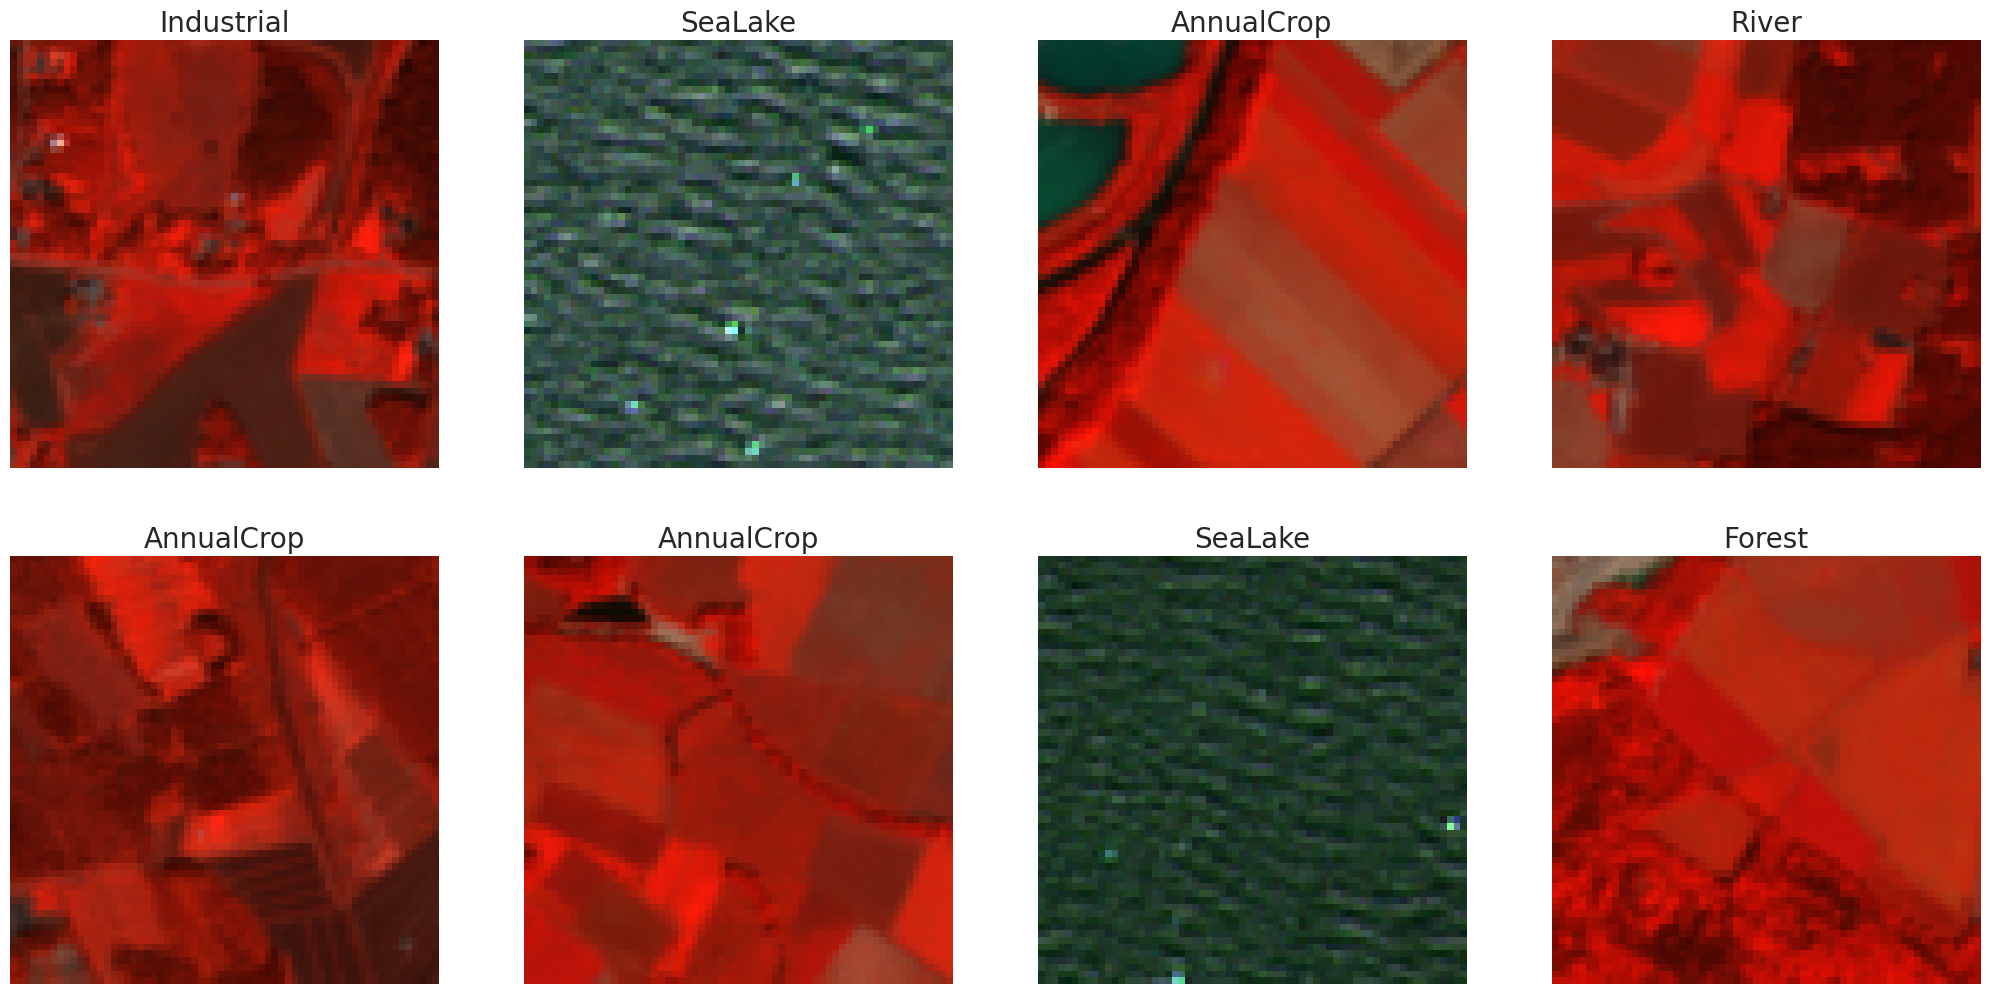

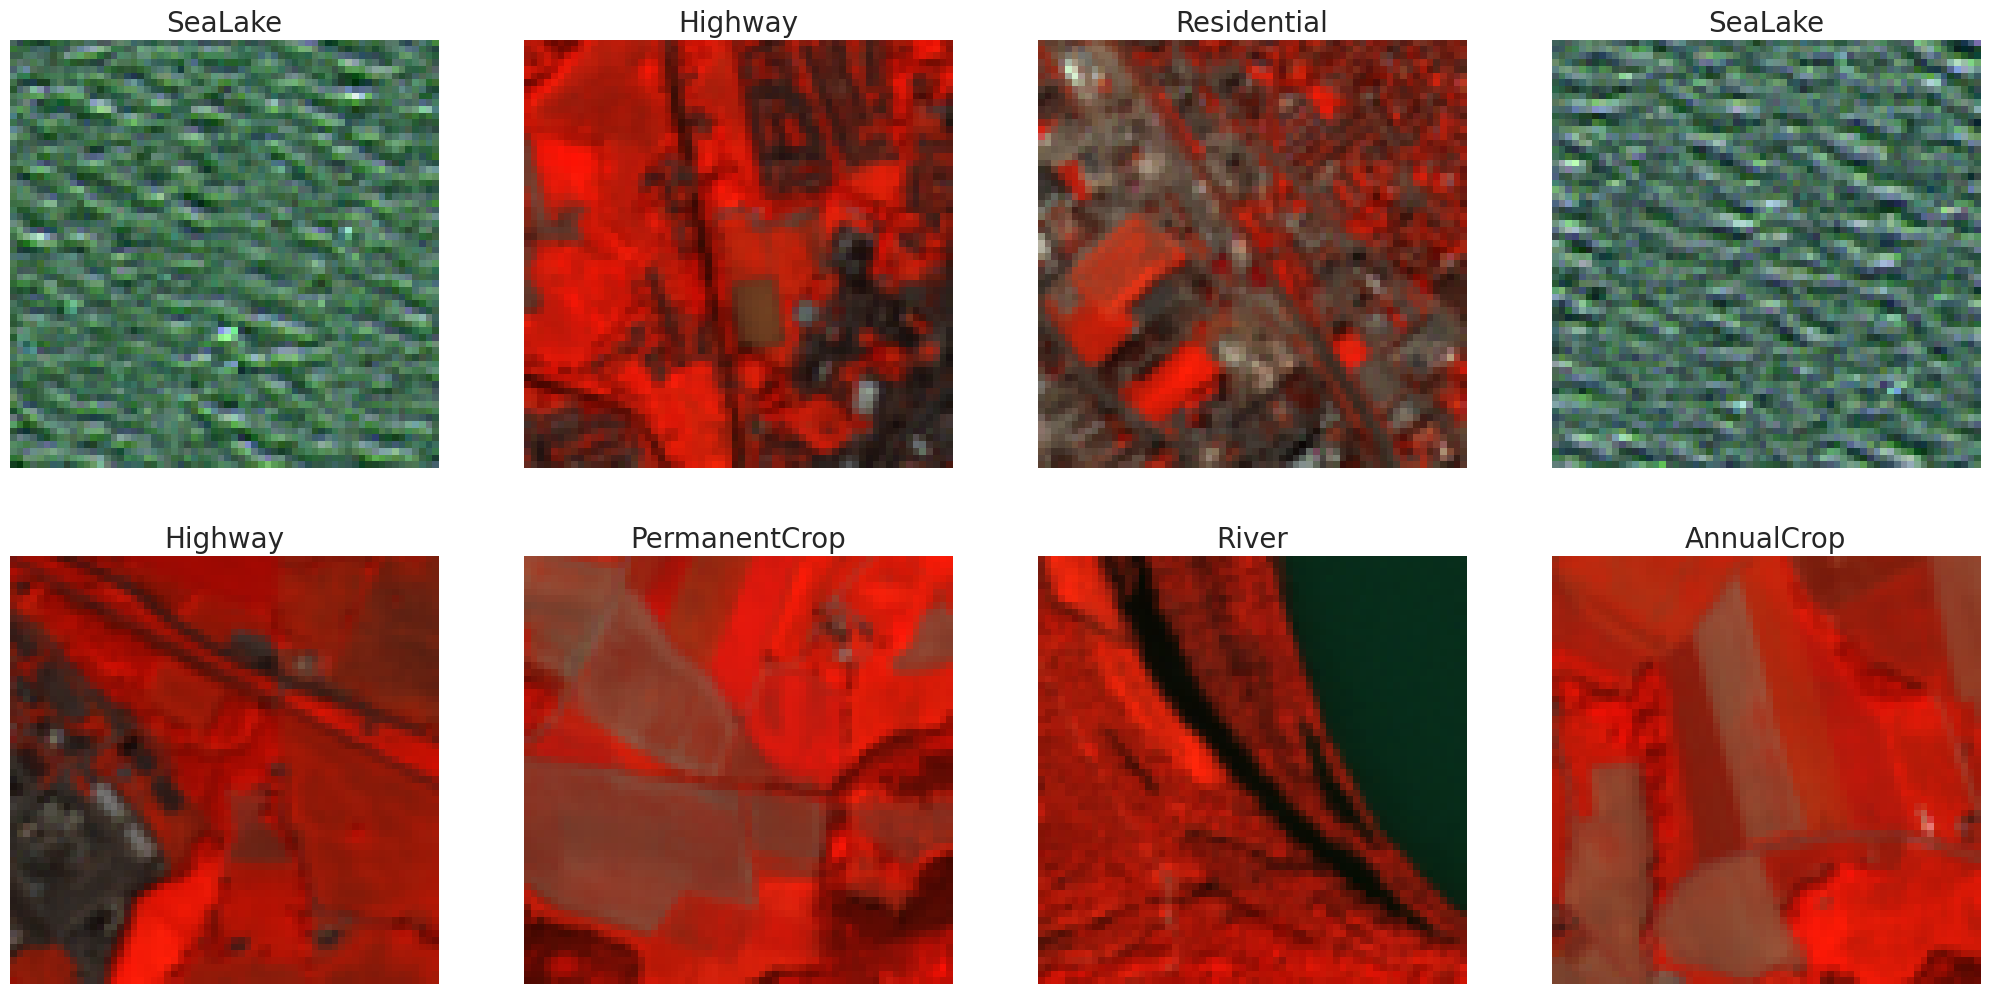

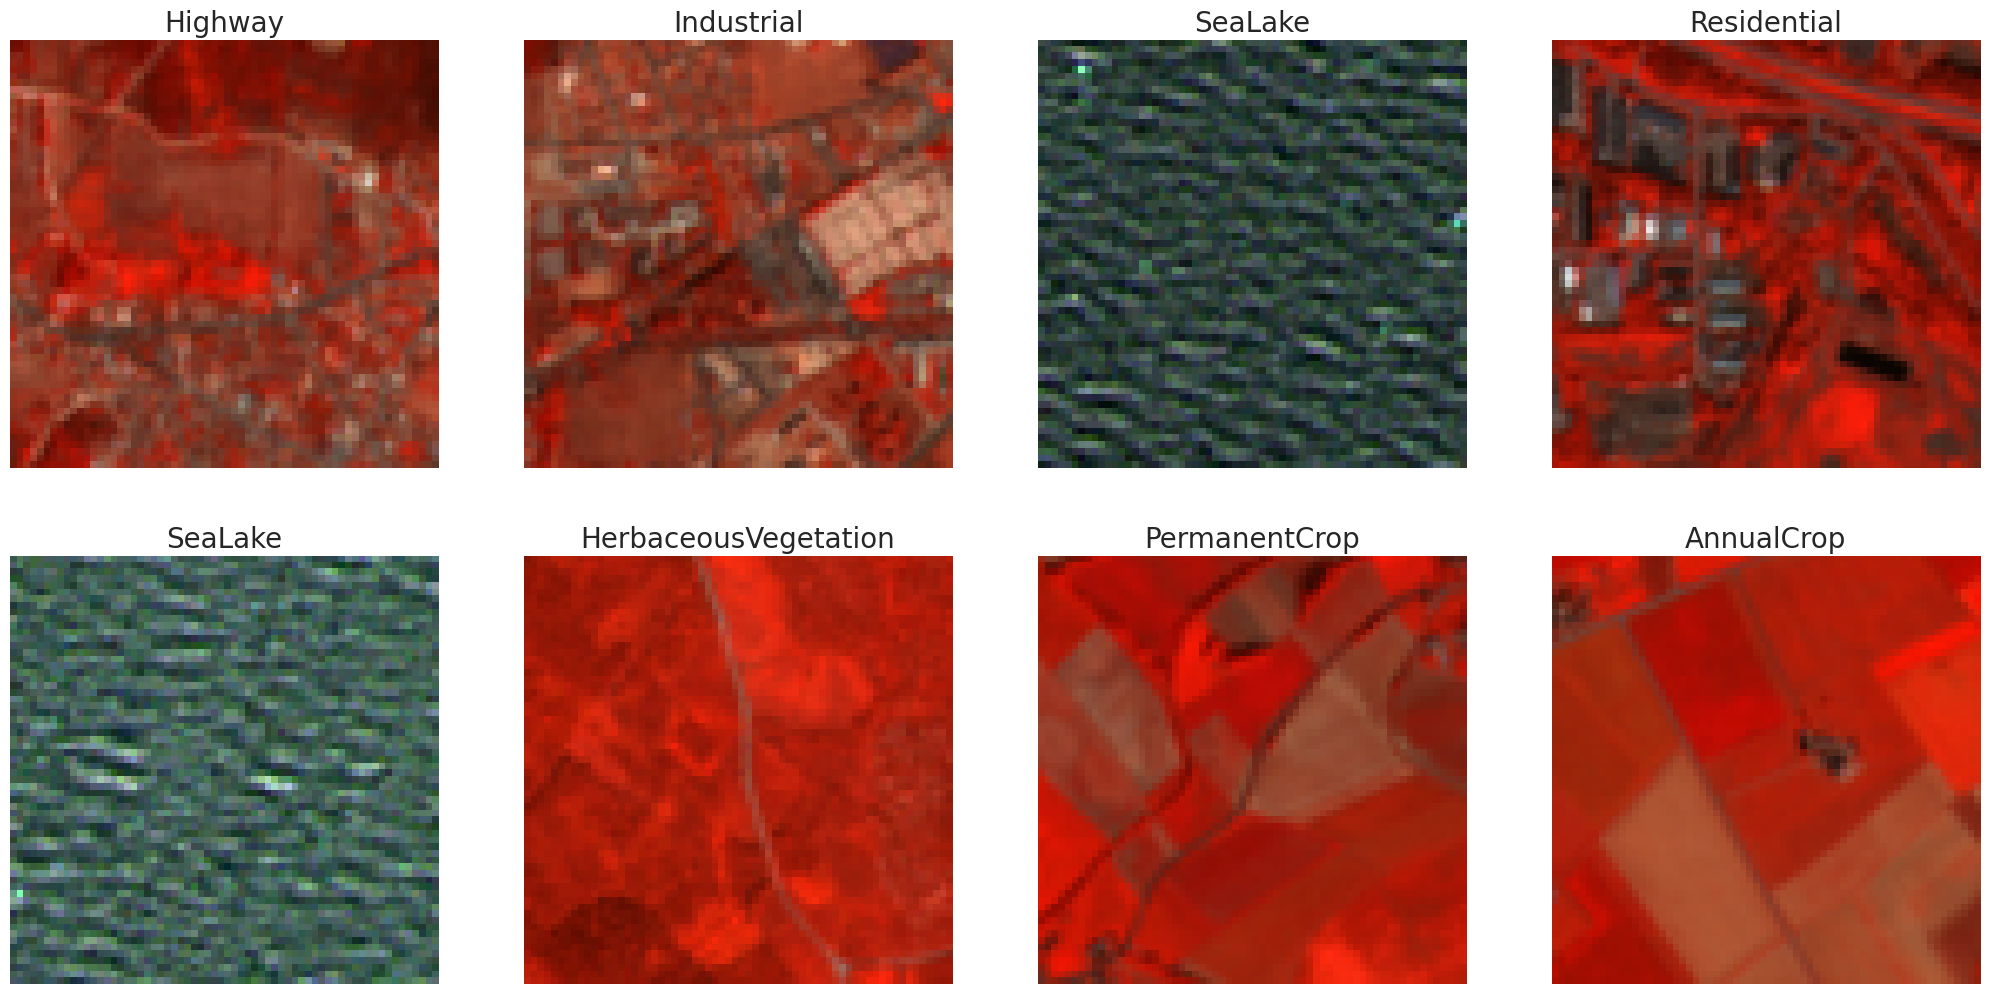

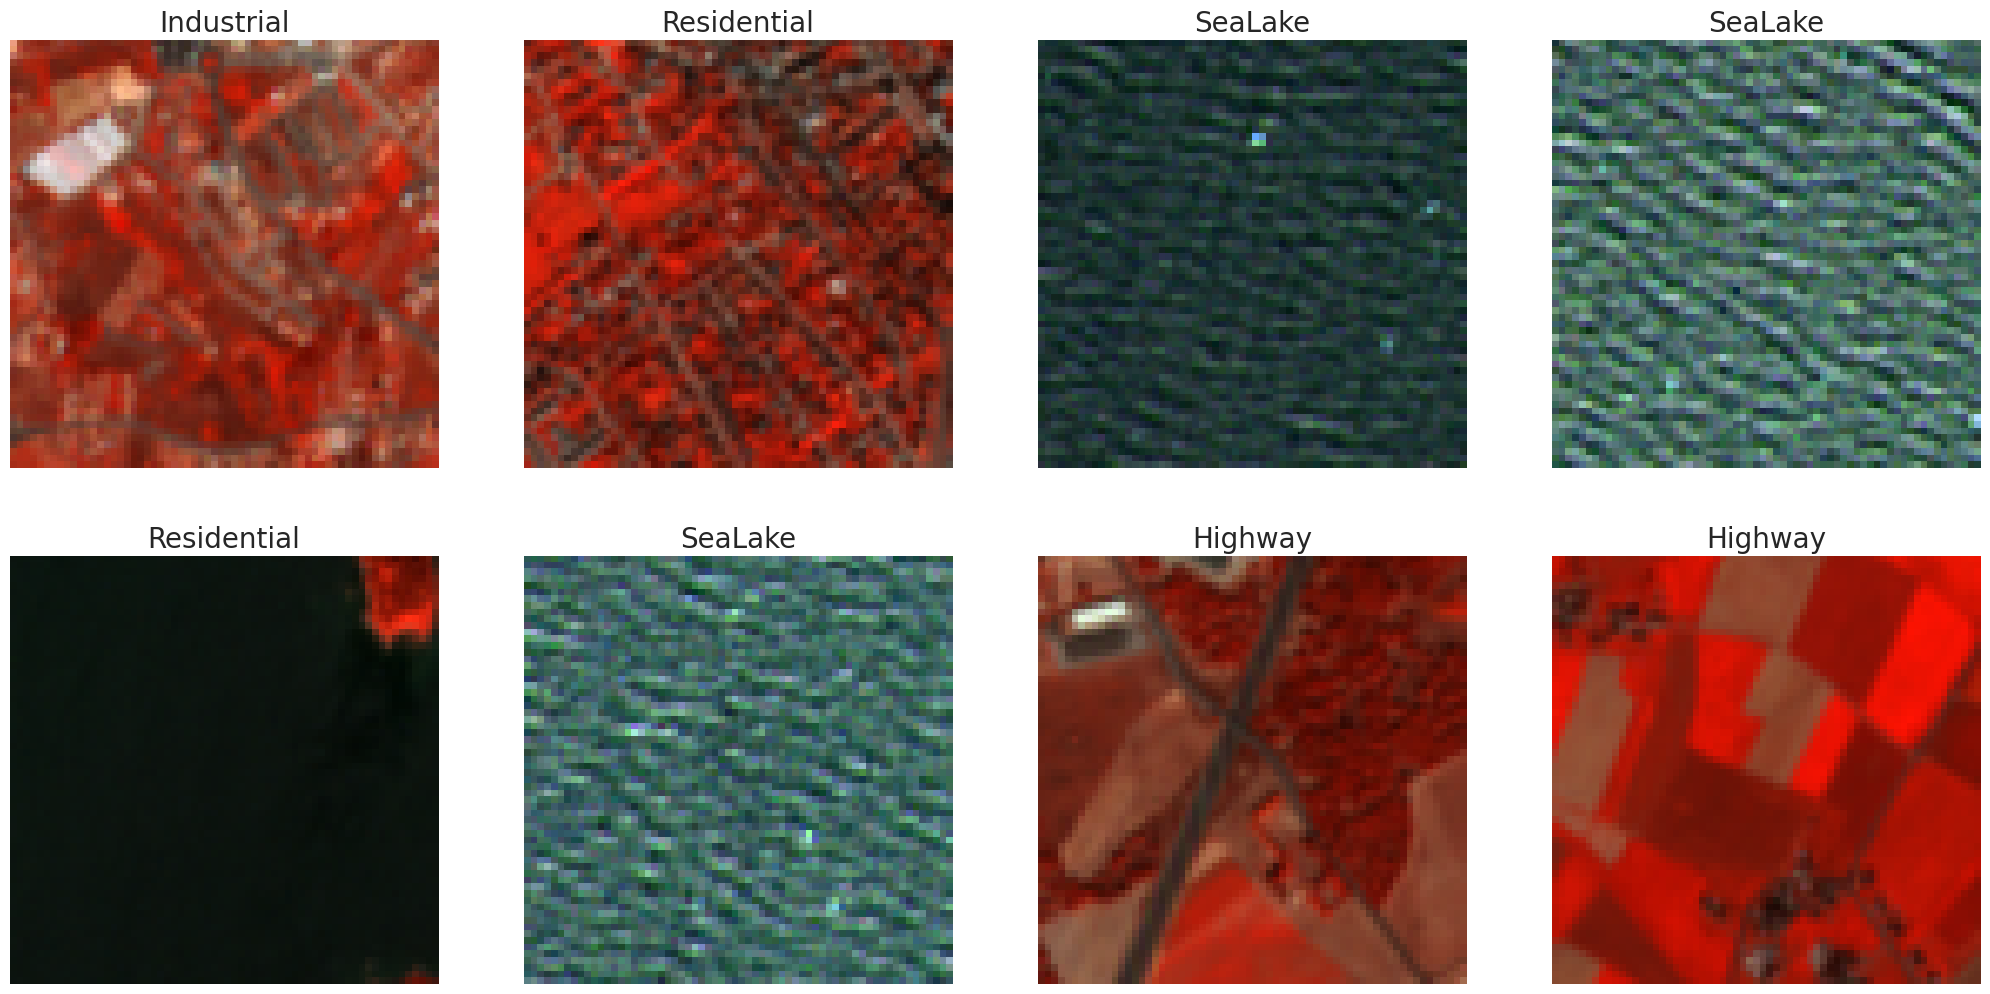

In [24]:
from pytorch_grad_cam import GradCAM

import torch
import random
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_cam_c = False
samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 5

for param in model_eval.backbone.parameters():
    param.requires_grad = True


# target_layer = [model_eval.backbone.layer4[-1].conv1]


for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        
        im_path = config.DATA_DIR + f"test/NoLabel/test_{samp_id}.npy"
        # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[7, 2, 1]].astype(np.float32)
        
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)
        img = img.clip(0, 1)
        
        
        if grad_cam_c:
            pass
            # img = images[idx].unsqueeze(0).requires_grad_(True).to(device)
            # cam = GradCAM(model=model_eval, target_layers=target_layer)
            # grayscale_cam = cam(input_tensor=img, targets=None)
            # cam_mask_tensor = torch.tensor(grayscale_cam).unsqueeze(0)
            # ax.imshow(cam_mask_tensor.squeeze(0).squeeze(0).cpu().numpy(), cmap='jet', alpha=0.1)
        else:
            ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(pred, fontsize=20)
        ax.axis('off')
        

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()